In [1]:
#!pip list

In [2]:
#!pip install "torch==1.4" "torchvision==0.5.0"
!curl -s https://course.fast.ai/setup/colab | bash

from fastai.vision import *
from fastai.metrics import error_rate
from urllib.request import urlopen
import requests
import json

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [3]:
response = json.loads(requests.get("http://arnelism.com/realestate/labelled/files.json").text)


In [4]:
!mkdir train
!mkdir train/facade
!mkdir train/interior

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train/facade’: File exists
mkdir: cannot create directory ‘train/interior’: File exists


In [5]:
facades = [url for url in response if "facade" in url]
interiors = [url for url in response if "interior" in url]


f = open("facades.csv", "a")
for url in facades:
  f.write(url + "\n")
f.close()

f = open("interiors.csv", "a")
for url in interiors:
  f.write(url + "\n")
f.close()

download_images("facades.csv", 'train/facade', max_pics=1000)
download_images("interiors.csv", 'train/interior', max_pics=1000)



In [6]:
classes = ["facade", "interior"]
path = "train"
for c in classes:
    print(c)
    verify_images(f"{path}/{c}", delete=True, max_size=1000)

facade


cannot identify image file <_io.BufferedReader name='train/facade/00000027.jpg'>
cannot identify image file <_io.BufferedReader name='train/facade/00000593.jpg'>
interior


In [7]:
path = "train"
data = ImageDataBunch.from_folder(
    path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4
    ).normalize(imagenet_stats)


In [8]:
data.classes

['facade', 'interior']

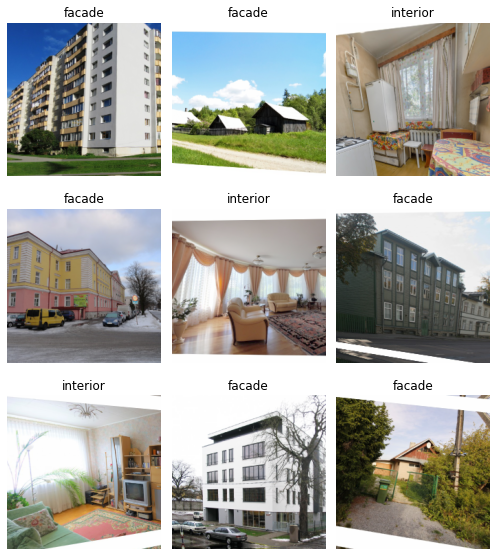

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2) #change to 5 for more training
interp = ClassificationInterpretation.from_learner(learn)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jovyan/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.221267,0.012765,0.997494,11:20
1,0.097826,0.012190,0.997494,10:04


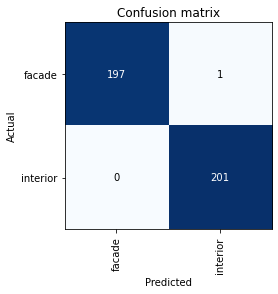

In [11]:
interp.plot_confusion_matrix()

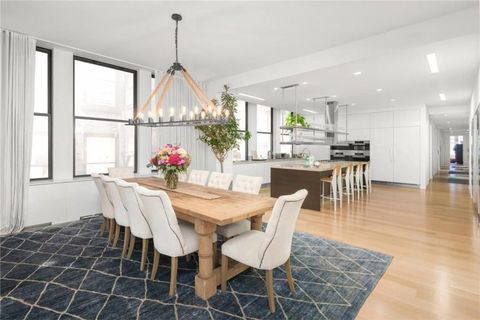

In [12]:
from urllib.request import urlopen
img = open_image(urlopen("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhips.hearstapps.com%2Fhmg-prod.s3.amazonaws.com%2Fimages%2Fhbz-jennifer-lopez-penthouse-01-1507665932.jpg%3Fcrop%3D1xw%3A1xh%3Bcenter%2Ctop%26resize%3D480%3A*&f=1&nofb=1"))
img

In [13]:
pred_class,pred_idx,outputs = learn.predict(img)
print(outputs)
prediction = (data.classes[int(pred_class)], max(outputs)*100)
print(prediction)

tensor([1.8784e-06, 1.0000e+00])
('interior', tensor(99.9998))


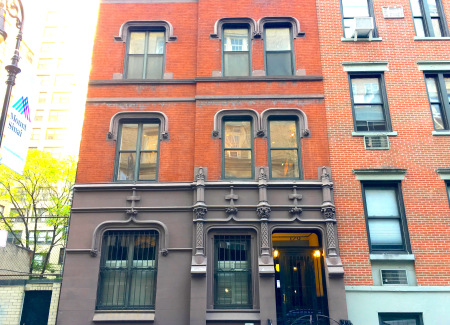

In [14]:
from urllib.request import urlopen
img = open_image(urlopen("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fephemeralnewyork.files.wordpress.com%2F2016%2F10%2Fapartmentfirstcloseup.jpg%3Fw%3D450%26h%3D326&f=1&nofb=1"))
img

In [16]:
pred_class,pred_idx,outputs = learn.predict(img)
print(outputs)
prediction = (data.classes[int(pred_class)], max(outputs)*100)
print(prediction)

tensor([9.9995e-01, 5.3120e-05])
('facade', tensor(99.9947))
